Work in Progress. Will be updated by Friday. Zheyu Ni

This file cleans the Airbnb data. 
1. deleted $ sign and comma in price.
2. visualize price distribution base on different features
3. Price range (0, 800) covers 95\% of the listings
4. create a dummy for the listing without review data
5. check how many listings have hotel/motel in name and agree with their room_type

The remaing data file contains \% of the raw data

In [346]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.cluster import KMeans

In [347]:
df = pd.read_csv('../listings_mar7_2023.csv')


In [348]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0         399.0
1          46.0
2         408.0
3          80.0
4        2138.0
          ...  
42446      40.0
42447      48.0
42448      46.0
42449      68.0
42450      48.0
Name: price, Length: 42451, dtype: float64

In [349]:
print(df['room_type'].value_counts())

Entire home/apt    29491
Private room       12180
Shared room          697
Hotel room            83
Name: room_type, dtype: int64


In [350]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [351]:
print(df['room_type'].value_counts())

Entire home/apt    29293
Private room       12051
Shared room          696
Hotel room           411
Name: room_type, dtype: int64


In [352]:
df.price.max()

99999.0

In [353]:
df = df[df['price'] < 1999]

In [354]:
df.price.max()

1995.0

In [355]:
X = df[['latitude','longitude']]

In [356]:
num_of_clusters = 250 ###feel free to change this
## Make a KMeans object
kmeans = KMeans(num_of_clusters,
                n_init='auto')

## Fit the kmeans object
kmeans.fit(X)

## get the clusters
clusters = kmeans.fit_predict(X)

In [357]:
X

,latitude,longitude
0,34.439250,-118.44409
1,34.048480,-117.76887
2,33.738420,-118.39580
3,33.748420,-118.31100
5,33.739280,-118.29911
...,...,...
42446,34.681137,-118.08123
42447,33.970150,-118.08644
42448,34.021560,-117.80541
42449,34.054760,-118.01578


C:\Users\Ricky\AppData\Local\Temp\ipykernel_3136\2905480532.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



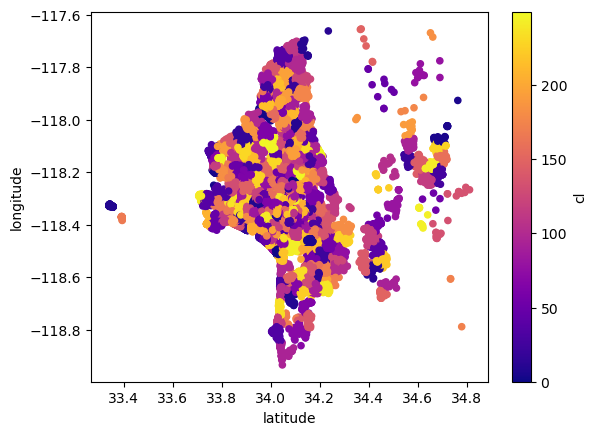

In [358]:
#Getting unique labels
X['cl'] = clusters
X.plot.scatter('latitude', 'longitude', c='cl', colormap='plasma')
plt.show()

In [359]:
df.loc[:,"cluster_num"] = kmeans.labels_

In [360]:
df['hotness_in_cluster_by_num_of_reviews'] = 0
df['hotness_in_cluster_by_num_of_reviews_per_month'] = 0

for i in np.arange(0,num_of_clusters):        
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews'] = df[df['cluster_num'] == i]['number_of_reviews'].sum()
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews_per_month'] = df[df['cluster_num'] == i]['reviews_per_month'].sum()

df['hotness_in_cluster_by_num_of_reviews'] = df['hotness_in_cluster_by_num_of_reviews']/df['hotness_in_cluster_by_num_of_reviews'].max()
df['hotness_in_cluster_by_num_of_reviews_per_month'] = df['hotness_in_cluster_by_num_of_reviews_per_month']/df['hotness_in_cluster_by_num_of_reviews_per_month'].max()

In [361]:
df[['hotness_in_cluster_by_num_of_reviews']].min(),df[['hotness_in_cluster_by_num_of_reviews']].max()

(hotness_in_cluster_by_num_of_reviews    0.000247
 dtype: float64,
 hotness_in_cluster_by_num_of_reviews    1.0
 dtype: float64)

In [362]:
df[['hotness_in_cluster_by_num_of_reviews_per_month']].min(),df[['hotness_in_cluster_by_num_of_reviews_per_month']].max()

(hotness_in_cluster_by_num_of_reviews_per_month    0.000441
 dtype: float64,
 hotness_in_cluster_by_num_of_reviews_per_month    1.0
 dtype: float64)

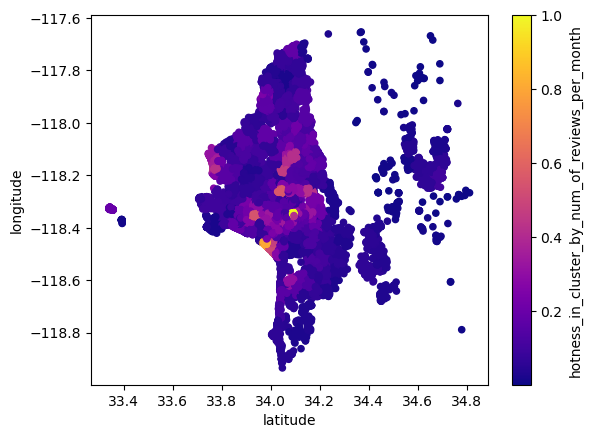

In [363]:
df.plot.scatter('latitude', 'longitude', c='hotness_in_cluster_by_num_of_reviews_per_month', colormap='plasma')
plt.show()

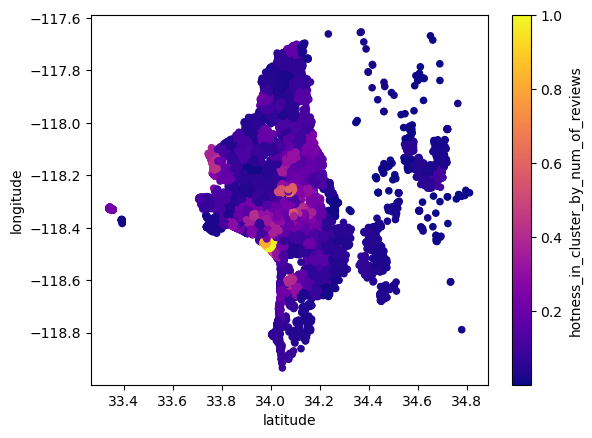

In [364]:
df.plot.scatter('latitude', 'longitude', c='hotness_in_cluster_by_num_of_reviews', colormap='plasma')
plt.show()

In [370]:
import plotly.express as px

In [367]:
#creates a map that has the shape of the united states

# fig = go.Figure(data=go.Scattergeo(
#         lon = df['longitude'],
#         lat = df['latitude'],
#         text = 'Num of reviews: ' + df['hotness_in_cluster_by_num_of_reviews_per_month'].astype(str),
#         marker_size = (df['hotness_in_cluster_by_num_of_reviews_per_month'])
#         ))
# fig.update_geos(fitbounds="locations")
# fig.update_layout(
#         title = 'Hotness based on number of reviews per month at each cluster',
# )
# fig.show()


In [368]:
plotdf = df[['latitude','longitude','hotness_in_cluster_by_num_of_reviews_per_month']]

In [374]:
fig = px.density_mapbox(plotdf,lat='latitude',lon='longitude')

fig.show()